# ToDo: 
+ ~~期待値がほぼ 0 になっている理由を探す。回避できるようなら回避~~
+ ~~C = 3 * n_qubits の理由~~ (特に理由はない？)
+ ~~QPU のばらつき改善~~
+ ~~2 次のトロッターにしてみる~~
+ ~~GHZ を中心に寄せる。このままだと不要な Trotter gate があるので。~~
+ 不要な interaction を削除

## わかったこと
+ ハミルトニアンをシフトさせなければ成功
+ times = [2 * np.pi * k / C for k in range(n_features)] は失敗
+ times = [np.pi * k / C for k in range(n_features)] は成功

In [1]:
%matplotlib inline
%pip freeze > requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from heisenberg_graph import (
    HeisenbergModel,
    get_n_steps,
    get_graph,
    get_positions,
    get_initial_layout,
    get_prob0,
    extract_probs,
)
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import mthree
import pickle
import networkx as nx
from datetime import datetime, timezone
import json
import math

In [4]:
# Set up the Qiskit Runtime service (this is an one-time setup)
# QiskitRuntimeService.save_account(
#     token="YOUR_API_TOKEN",
#     channel="ibm_quantum",
# )

In [5]:
# Option1: Use IBM Quantum backend.
# Load saved credentials
service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, interactional=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()

noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['id', 'sx', 'measure', 'cz', 'x', 'reset']>)


# データセット作成 $f(H) = e^{-\beta H}$

In [6]:
n_samples = 70
n_qubits = 12
beta = 1

graph_type = "line"
# ghz_qubits = list(range(n_qubits // 2))
# ghz_qubits = list(range(0, n_qubits, 2))
# print(f"GHZ qubits: {ghz_qubits}")

## Create graph (Demo)

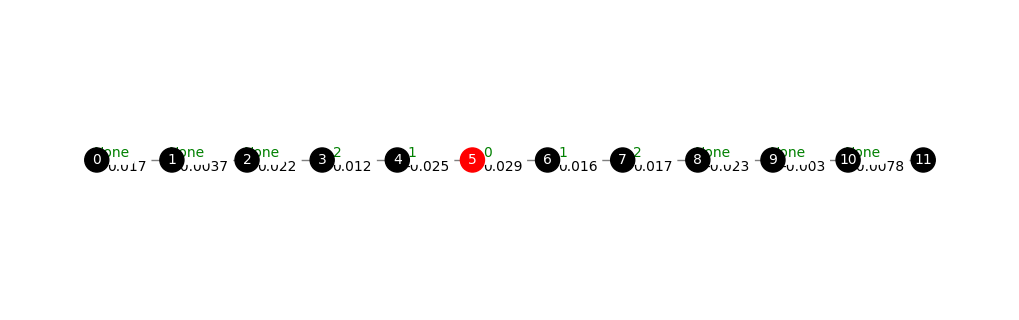

In [7]:
rng = np.random.default_rng(42)
G = get_graph(n_qubits, rng, graph_type)

positions = get_positions(n_qubits, graph_type)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

In [8]:
# State |0011...1100> (center qubits are 1 and the rest are 0)
leftmost = n_qubits // 4
rightmost = leftmost + n_qubits // 2 - 1
index = []
for i in range(n_qubits):
    if leftmost <= i <= rightmost:
        index.append("1")
    else:
        index.append("0")

index = "".join(index)
print(f"binary index: {index}")
state = Statevector.from_label(index)

print(f"decimal: {int(index, 2)}")
print(state[int(index, 2)])

binary index: 000111111000
decimal: 504
(1+0j)


## Non Trotter simulation (directly compute the expectation value)

In [9]:
data = []
graphs = []
# For debugging
# eigvals_abs_max = []
rng = np.random.default_rng(42)

for i in range(n_samples):
    print(f"Sample {i}/{n_samples}")
    G = get_graph(n_qubits, rng, graph_type)
    Js = [G.edges[edge]["J"] for edge in G.edges]
    heisenberg = HeisenbergModel(n_qubits, G)

    H = heisenberg.H
    # H = H.to_matrix(sparse=True)

    # state is big endian, so we need to reverse the qubits of the Hamiltonian
    H = Operator(H).reverse_qargs().to_matrix()
    H = scipy.sparse.csr_matrix(H)
    norm = scipy.sparse.linalg.norm(H, ord=2)

    fH = scipy.sparse.linalg.expm(-beta * H)
    # Compute the expectation value <state|exp(-beta*H)|state>
    y = np.vdot(state, fH @ state).real

    data.append({"Js": Js, "expected_value": y, "norm": norm})
    graphs.append(G)

    # For debugging
    # eigvals_abs_max.append(max(np.abs(scipy.linalg.eigvals(H.toarray()))))

df = pd.DataFrame(data)
df

Sample 0/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00021235]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 19 instead with accuracy 
0.00015738486464079673.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00015738]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('sps

Sample 1/70
Sample 2/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00029379]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.0002937935630508067.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00029379]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 3/70
Sample 4/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00025681]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 15 instead with accuracy 
0.000176089780862281.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00017609]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 5/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00025825]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 9 instead with accuracy 
0.00017328510728933965.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00017329]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 6/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[9.73331344e-05]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 20 instead with accuracy 
7.159702021717895e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[7.15970202e-05]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


KeyboardInterrupt: 

## Pre-process data

In [10]:
df["expected_value"].describe()

count    70.000000
mean      1.006832
std       0.055220
min       0.896964
25%       0.969244
50%       1.006104
75%       1.043701
max       1.158165
Name: expected_value, dtype: float64

In [11]:
df["norm"].describe()

count    70.000000
mean      0.291823
std       0.052357
min       0.179178
25%       0.253033
50%       0.295732
75%       0.331915
max       0.397774
Name: norm, dtype: float64

In [12]:
# # Query the 80% quantile
# q = df["expected_value"].quantile(0.8)
# filtered_index = df.query(f"expected_value < @q").index
# diffrence = df.index.difference(filtered_index)
# print(f"Outliers: {diffrence}")

# # Remove outliers
# df = df.drop(diffrence).reset_index(drop=True)
# graphs = [graph for i, graph in enumerate(graphs) if i not in diffrence]

In [13]:
display(df)

n_samples = len(df)
print(f"Number of samples: {n_samples}")
df["expected_value"].describe()

,Js,expected_value,norm
0,"[0.0166033968821796, -0.0037043369847241034, 0...",0.950994,0.300042
1,"[0.02586454477870314, 0.008719098186706943, 0....",1.010314,0.286416
2,"[0.028527152993630504, 0.02382552250437562, 0....",1.020843,0.327132
3,"[-0.007850926906977643, -0.001845102346920733,...",1.046820,0.227290
4,"[0.020136957660315216, 0.018470567121018293, -...",1.022114,0.270980
...,...,...,...
65,"[-0.019080039699783783, 0.0037679232568225557,...",1.070530,0.360786
66,"[-0.015389902333034033, -0.026331488853431367,...",1.091646,0.353099
67,"[-0.011995662497961305, -0.0064166195649637894...",1.092546,0.285954
68,"[0.017004917425853597, 0.020679012497876147, -...",0.972772,0.277375


Number of samples: 70


count    70.000000
mean      1.006832
std       0.055220
min       0.896964
25%       0.969244
50%       1.006104
75%       1.043701
max       1.158165
Name: expected_value, dtype: float64

In [14]:
df["norm"].describe()

count    70.000000
mean      0.291823
std       0.052357
min       0.179178
25%       0.253033
50%       0.295732
75%       0.331915
max       0.397774
Name: norm, dtype: float64

## Check eigvals and Configure params

In [15]:
n_features = 10  # Number of Fourier features

# Parameters for the Fourier feature generation
# For shifted Hamiltonian
# C = 20 * n_qubits  # upper bound for eigenvalues (WHY?)
# times = [2 * np.pi * k / C for k in range(n_features)]

# For unshifted Hamiltonian
# C = 10 * n_qubits  # upper bound for eigenvalues
# C = max(df["norm"]) * 10
C = max(df["norm"])
times = [np.pi * k / C for k in range(n_features)]

print(f"C: {C}")
print(f"times: {times}")

C: 0.39777364186486336
times: [0.0, 7.897940745548682, 15.795881491097363, 23.693822236646046, 31.591762982194727, 39.489703727743404, 47.38764447329209, 55.28558521884077, 63.18352596438945, 71.08146670993813]


In [16]:
# Only for using Docker container
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [17]:
CURRENT_TIME = (
    datetime.now(timezone.utc).isoformat(timespec="minutes").replace("+00:00", "Z")
)

path = f"./data/{CURRENT_TIME}"
os.makedirs(path, exist_ok=True)
print("Note: This CURRENT_TIME is used for other notebooks.")
print(f"CURRENT_TIME: {CURRENT_TIME}")
print(f"Saving data to {path}")

Note: This CURRENT_TIME is used for other notebooks.
CURRENT_TIME: 2024-12-19T04:50Z
Saving data to ./data/2024-12-19T04:50Z


In [18]:
# Save parameters

# Save the graphs as a binary file
with open(f"{path}/params_object.pkl", "wb") as f:
    pickle.dump(
        {
            "graphs": graphs,
            "Js": df["Js"].values,
            "expected_values": df["expected_value"].values,
        },
        f,
    )

# Save the parameters as a JSON file
with open(f"{path}/params_text.json", "w") as f:
    json.dump(
        {
            "n_samples": n_samples,
            "n_qubits": n_qubits,
            "graph_type": graph_type,
            "backend_qpu_name": backend_qpu.name,
            "beta": beta,
            "C": C,
            "n_features": n_features,
            "times": times,
        },
        f,
        indent=4,
    )